In [98]:
# Suppress TensorFlow INFO and WARNING messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Standard Library Imports
import importlib
from glob import glob
import warnings
from typing import List

# External Library Imports
import yaml
import numpy as np
from patoolib import extract_archive
from matplotlib import pyplot as plt
from matplotlib import cm

# Local Module Imports
import utils
importlib.reload(utils)
from utils import wkt2masc, load_images_from_folder, frame_to_label

import polygon_handle
importlib.reload(polygon_handle)
from polygon_handle import masks_to_polygons

In [96]:
current_dir = os.getcwd()
BASE_DIR = os.path.dirname(current_dir)
dataset_dir = os.path.join(BASE_DIR, 'dataset')
data_dir = os.path.join(BASE_DIR, 'data')
config_file = os.path.join(BASE_DIR, 'config.yml')

DATA = "full"  # "full" or "sampled"
MODE = "interpolation" # "interpolation" or "extrapolation"

In [112]:
# if there isn´t unrar installed, install it with: sudo apt-get install unrar (linux)
# for windows, install it from: https://www.rarlab.com/rar_add.htm (unrarw32.exe)

dataset_path = os.path.join(dataset_dir, "BurnedAreaUAV_dataset")
if not os.path.exists(dataset_path):
    extract_archive(os.path.join(dataset_dir, "BurnedAreaUAV_dataset_v1.rar"), program="unrar", outdir=dataset_dir)
    os.remove(os.path.join(dataset_dir, "BurnedAreaUAV_dataset_v1.rar"))

with open(config_file, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

### Masks directories creation and conversion

In [4]:
dataset_train_msks_path = os.path.join(dataset_path, 'PNG', 'train', 'masks')
dataset_test_msks_path = os.path.join(dataset_path, 'PNG', 'test', 'masks')
train_msks_list = [os.path.basename(x) for x in glob(dataset_train_msks_path + "/*.png")]
test_msks_list = [os.path.basename(x) for x in glob(dataset_test_msks_path + "/*.png")]

# convert WKT files to segmentation masks : full train, sampled train and test
train_masks_dir = os.path.join(BASE_DIR, config["data"]["train_dir"], "masks")
if not os.path.exists(train_masks_dir):
    os.makedirs(train_masks_dir)

test_masks_dir = os.path.join(BASE_DIR, config["data"]["test_dir"], "masks")
if not os.path.exists(test_masks_dir):
    os.makedirs(test_masks_dir)

sampled_masks_txt_path = os.path.join(BASE_DIR, config["data"]["sampled_masks_txt"])
with open(sampled_masks_txt_path, "r", encoding="utf-8") as f:
    polygons = f.readlines()
    # extract indexes
    indexes = [int(polygon.split(",")[0]) for polygon in polygons]

train_sampled_masks_dir = os.path.join(BASE_DIR, config["data"]["train_sampled_dir"], "masks")
if not os.path.exists(train_sampled_masks_dir):
    os.makedirs(train_sampled_masks_dir)

wkt2masc(
    wkt_file=os.path.join(BASE_DIR, config["data"]["train_wkt"]),
    images_path=train_masks_dir,
    orig_dims=config["data"]["original_vid_dims"],
    height=config["data"]["input_size"][0],
    width=config["data"]["input_size"][1],
)

wkt2masc(
    wkt_file=os.path.join(BASE_DIR, config["data"]["test_wkt"]),
    images_path=test_masks_dir,
    orig_dims=config["data"]["original_vid_dims"],
    height=config["data"]["input_size"][0],
    width=config["data"]["input_size"][1],
)

wkt2masc(
    wkt_file=os.path.join(BASE_DIR, config["data"]["sampled_masks_wkt"]),
    images_path=train_sampled_masks_dir,
    orig_dims=config["data"]["original_vid_dims"],
    height=config["data"]["input_size"][0],
    width=config["data"]["input_size"][1],
)


    --------------------------------------
    # Properties of the resulting masks
    # Width: 512, Height: 512
    # Number of masks to create: 226
    --------------------------------------
    


  0%|          | 0/226 [00:00<?, ?it/s]

100%|██████████| 226/226 [00:00<00:00, 606.18it/s]



    --------------------------------------
    # Properties of the resulting masks
    # Width: 512, Height: 512
    # Number of masks to create: 23
    --------------------------------------
    


100%|██████████| 23/23 [00:00<00:00, 639.11it/s]



    --------------------------------------
    # Properties of the resulting masks
    # Width: 512, Height: 512
    # Number of masks to create: 13
    --------------------------------------
    


100%|██████████| 13/13 [00:00<00:00, 674.56it/s]


In [5]:
# reconstruct the masks labels
msks_train_paths = sorted(glob(os.path.join(train_masks_dir, "*.png")))
msks_train_labels = [int(os.path.basename(m).split("_")[1].split(".")[0]) * 100 for m in msks_train_paths]
msks_test_paths = sorted(glob(os.path.join(test_masks_dir, "*.png")))
msks_test_labels = [int(os.path.basename(m).split("_")[1].split(".")[0]) * 100 + 20250 for m in msks_test_paths]
msks_train_sampled_paths = sorted(glob(os.path.join(train_sampled_masks_dir, "*.png")))
msks_train_sampled_labels = [100 * i for i in indexes]

print("Train masks:", len(msks_train_paths))
print("Train sampled masks:", len(msks_train_sampled_paths))
print("Test masks:", len(msks_test_paths))

Train masks: 226
Train sampled masks: 13
Test masks: 23


### Load masks and process labels

In [23]:
if DATA == 'full':
    TRAIN_DIR = os.path.join(BASE_DIR, config["data"]["train_dir"], "masks")
else:
    TRAIN_DIR = os.path.join(BASE_DIR, config["data"]["train_sampled_dir"], "masks")
TEST_DIR = os.path.join(BASE_DIR, config["data"]["test_dir"], "masks")

# train and test numpy arrays
train_masks = load_images_from_folder(TRAIN_DIR, target_size=config["data"]["input_size"][:2])
test_masks = load_images_from_folder(TEST_DIR, target_size=config["data"]["input_size"][:2])

# labels normalization and reshaping
max_val = np.max(msks_train_labels)
train_labels = (msks_train_labels/max_val).astype(np.float32)
train_labels = np.expand_dims(train_labels, axis=-1)
test_labels = (msks_test_labels/max_val).astype(np.float32)
test_labels = np.expand_dims(test_labels, axis=-1)

print("-" * 58)
print(f"{'Variable':<15} {'Shape':<18} {'Dtype':<9} {'Max':<7} {'Min':<8}")
print("-" * 58)
print(f"{'train_imgs':<15} {str(train_masks.shape):<18} {str(train_masks.dtype):<8}  {np.max(train_masks):.1f}    {np.min(train_masks):.1f}")
print(f"{'train_labels':<15} {str(train_labels.shape):<18} {str(train_labels.dtype):<8}  {np.max(train_labels):.1f}     {np.min(train_labels):.1f}")
print("~" * 58)
print(f"{'test_imgs':<15} {str(test_masks.shape):<18} {str(test_masks.dtype):<8}  {np.max(test_masks):.1f}    {np.min(test_masks):.1f}")
print(f"{'test_labels':<15} {str(test_labels.shape):<18} {str(test_labels.dtype):<8}  {np.max(test_labels):.1f}     {np.min(test_labels):.1f}")
print("-" * 58)

----------------------------------------------------------
Variable        Shape              Dtype     Max     Min     
----------------------------------------------------------
train_imgs      (226, 512, 512, 1) float32   1.0    -1.0
train_labels    (226, 1)           float32   1.0     0.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
test_imgs       (23, 512, 512, 1)  float32   1.0    -1.0
test_labels     (23, 1)            float32   1.0     0.9
----------------------------------------------------------


### Models

In [13]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Activation, Dense, Lambda, Input, Dense
from tensorflow.keras.layers import MaxPooling2D, Flatten, Reshape, Concatenate
from tensorflow.keras.layers import SeparableConv2D, Conv2DTranspose
from tensorflow.keras import backend as K 
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [14]:
def deconv_block(input, filters, f_init="he_normal"):
   """
   Apply two convolutional layers with ReLU activation function.

   Args:
         input (tensor): Input tensor to the block.
         filters (int): Number of filters in the convolutional layers.
        
   Returns:
         tensor: Output tensor of the block with ReLU activation.
   """   
   x = Conv2DTranspose(filters, 
                      kernel_size = (4,4), 
                     strides=2,
                     kernel_initializer = f_init,
                     data_format = "channels_last", 
                     padding="same")(input)

   x = SeparableConv2D(filters, 
                     kernel_size = (4,4), 
                     depthwise_initializer = f_init,
                     pointwise_initializer = f_init,
                     padding="same")(x)
   x = Activation(tf.nn.leaky_relu)(x)

   x = SeparableConv2D(filters, 
                     kernel_size = (4,4), 
                     depthwise_initializer = f_init,
                     pointwise_initializer = f_init,
                     padding="same")(x)
   activation = Activation(tf.nn.leaky_relu)(x)
   
   return activation

In [15]:
def conv_block(input, filters, f_init="he_normal"):
    """
    Apply two convolutional layers with ReLU activation function.

    Args:
        input (tensor): Input tensor to the block.
        filters (int): Number of filters in the convolutional layers.

    Returns:
        tensor: Output tensor of the block with ReLU activation.
    """
    x = SeparableConv2D(filters, 
                        kernel_size = (4,4), 
                        depthwise_initializer = f_init,
                        pointwise_initializer = f_init,
                        padding="same")(input)
    x = Activation(tf.nn.leaky_relu)(x)

    x = SeparableConv2D(filters, 
                        kernel_size = (4,4), 
                        depthwise_initializer = f_init,
                        pointwise_initializer = f_init,
                        padding="same")(x)
    ativ = Activation(tf.nn.leaky_relu)(x)

    m_pool = MaxPooling2D(pool_size=(2, 2),
                          strides=2,
                          data_format="channels_last",
                          padding='same')(ativ)
    
    return m_pool

In [16]:
def sampler(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [33]:
H, W, C = config["data"]["input_size"]

#--------
# Encoder
#--------

encoder_inputs = Input(shape=(H, W, C))
# Reshape input to 2D image

x = conv_block(encoder_inputs, 
               config["CVAE"]["ref_filters"]*2, 
               config["CVAE"]["w_init"])
x = conv_block(x, 
               config["CVAE"]["ref_filters"]*1, 
               config["CVAE"]["w_init"])
x = Flatten()(x)
x = Dense(64, activation="leaky_relu")(x)

# VAE specific layers for mean and log variance
z_mean = Dense(config["CVAE"]["latent_dim"],  activation="leaky_relu", name="z_mean")(x)
z_log_var = Dense(config["CVAE"]["latent_dim"], activation="leaky_relu", name="z_log_var")(x)

# Sampling layer to sample z from the latent space
z = Lambda(sampler, output_shape=(config["CVAE"]["latent_dim"],), name='z')([z_mean, z_log_var])

# Instantiate encoder model
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

#--------
# Decoder
#--------

latent_inputs = Input(shape=(config["CVAE"]["latent_dim"],), name='z_sampling')
label_size = len(train_labels[0])
label_inputs = Input(shape=(label_size,), name='label')
decoder_inputs = Concatenate()([latent_inputs, label_inputs])
x = Dense(64*64*64, activation="leaky_relu")(decoder_inputs)
x = Reshape((128,128,16))(x)
x = deconv_block(x, config["CVAE"]["ref_filters"]*2, 
                 config["CVAE"]["w_init"])
x = deconv_block(x, config["CVAE"]["ref_filters"]*4, 
                 config["CVAE"]["w_init"])
decoder_output = Conv2DTranspose(1, 3, activation="tanh", padding="same")(x)

decoder = Model([latent_inputs, label_inputs], decoder_output, name="decoder")

#-----------------
# Conditional VAE
#-----------------

outputs = decoder([encoder(encoder_inputs)[2], label_inputs])
cvae = Model([encoder_inputs, label_inputs], outputs, name='cvae')
cvae.summary()

Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 encoder (Functional)        [(None, 64),                 3357281   ['input_2[0][0]']             
                              (None, 64),                 6                                       
                              (None, 64)]                                                         
                                                                                                  
 label (InputLayer)          [(None, 1)]                  0         []                            
                                                                                               

In [34]:
def mse_kl_loss(y_true, y_pred, beta: float = 1.0):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    squared_difference = tf.square(y_true - y_pred)
    reconstruction = tf.reduce_mean(squared_difference, axis=-1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed from as both dist. are Gaussian
    kl_divergence = 0.5 * tf.reduce_sum(tf.exp(z_log_var) + tf.square(z_mean) - 1. - z_log_var, axis=-1)
    return reconstruction + beta*kl_divergence

In [42]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.5,
    mode="min",
    patience=30,
    verbose=1,
    min_lr=1e-8
    )

checkpoint_dir = os.path.join(BASE_DIR, config["data"]["checkpoint_dir"])
checkpoint_filepath = os.path.join(checkpoint_dir, f'cvae_{DATA}.h5')

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_best_only=True,
    mode="auto",
    verbose=1,
    monitor="loss")

In [43]:
cvae.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = 3e-4),
             loss=mse_kl_loss)

In [46]:
history = cvae.fit([train_masks, train_labels],
                     train_masks,
                     epochs=config["CVAE"]["epochs"],
                     batch_size=1,
                     validation_data=([test_masks, test_labels], test_masks),
                     callbacks=[reduce_lr, checkpoint],
                     )

Train on 226 samples, validate on 23 samples
Epoch 1/500
226/226 [==============================] - ETA: 0s - loss: 0.4863

/home/tiagociic/miniconda3/envs/cvae/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: loss improved from inf to 0.48629, saving model to /home/tiagociic/Projectos/spatiotemporal-vae-reconstruction/checkpoints/cvae_full.h5


/home/tiagociic/miniconda3/envs/cvae/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
DEBUG:h5py._conv:Creating converter from 5 to 3


226/226 [==============================] - 29s 128ms/sample - loss: 0.4863 - val_loss: 0.3735 - lr: 3.0000e-04
Epoch 2/500
226/226 [==============================] - ETA: 0s - loss: 0.2723
Epoch 2: loss improved from 0.48629 to 0.27230, saving model to /home/tiagociic/Projectos/spatiotemporal-vae-reconstruction/checkpoints/cvae_full.h5
226/226 [==============================] - 29s 129ms/sample - loss: 0.2723 - val_loss: 0.3268 - lr: 3.0000e-04
Epoch 3/500
226/226 [==============================] - ETA: 0s - loss: 0.2346
Epoch 3: loss improved from 0.27230 to 0.23461, saving model to /home/tiagociic/Projectos/spatiotemporal-vae-reconstruction/checkpoints/cvae_full.h5
226/226 [==============================] - 29s 129ms/sample - loss: 0.2346 - val_loss: 0.2758 - lr: 3.0000e-04
Epoch 4/500
226/226 [==============================] - ETA: 0s - loss: 0.2008
Epoch 4: loss improved from 0.23461 to 0.20075, saving model to /home/tiagociic/Projectos/spatiotemporal-vae-reconstruction/checkpoints

In [62]:
import  visualization             # the module to reload
# reload the module
importlib.reload(visualization)
from visualization import plot_learning_curves

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/tiagociic/miniconda3/envs/cvae/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/tiagociic/miniconda3/envs/cvae/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/tiagociic/miniconda3/envs/cvae/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='sc

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/tiagociic/miniconda3/envs/cvae/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansIndicSiyaqNumbers-Regular.ttf', name='Noto Sans Indic Siyaq Numbers', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSerifTibetan-Regular.ttf', name='Noto Serif Tibetan', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansDisplay-Regular.ttf', name='Noto Sans Display', style='normal', variant='normal', weight=

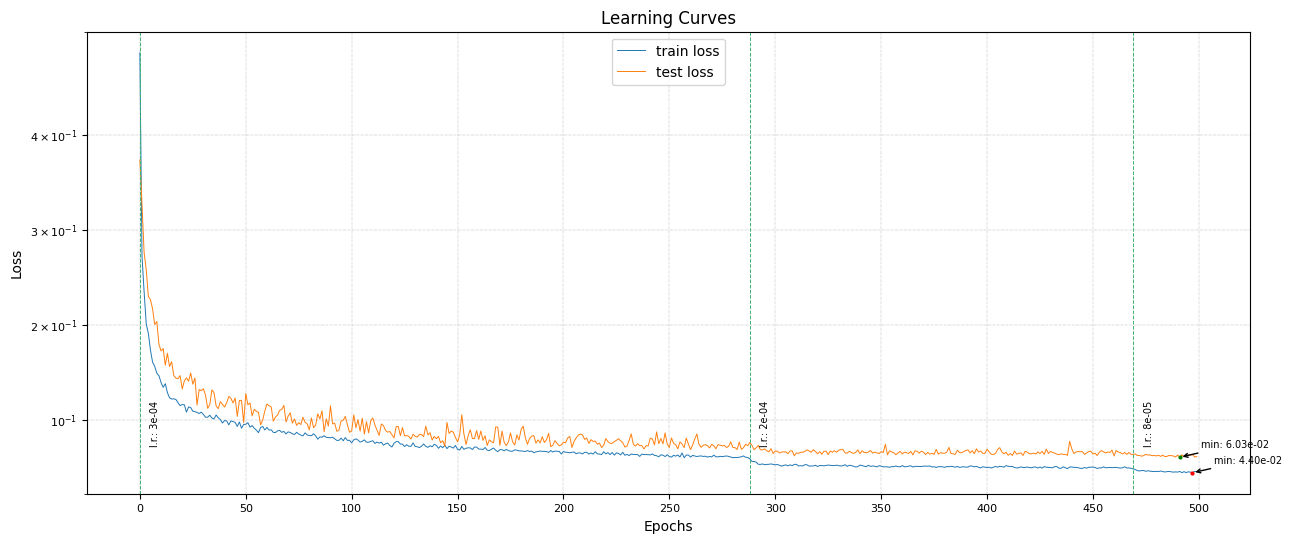

In [63]:
# plot history
# plt.rcParams.update({'figure.max_open_warning': 0})
plot_learning_curves(history,log_scale=True)

In [64]:
# load the best model
cvae.load_weights(checkpoint_filepath)

DEBUG:h5py._conv:Creating converter from 3 to 5


In [75]:


def plot_generated_imgs(model, frames_num_list: List[int]):
    """
    Plots generated images from a trained model.

    Parameters:
    model (keras.Model or torch.nn.Module): The trained model.
    frames_num_list (List[int]): The list of frames numbers.

    Returns:
    None

    Side effects:
    Displays the generated images using matplotlib.
    """
    # Check if model and frames_num_list are not None
    if model is None:
        raise ValueError("No model was provided. Please provide a trained model.")
    if frames_num_list is None:
        raise ValueError("No frames number list was provided. Please provide a list of frames numbers.")

    # Generate images from the latent space
    z = np.random.normal((len(frames_num_list), model.input_shape[1]))
    if hasattr(model, 'forward'):
        # PyTorch model
        z = torch.from_numpy(z).float()
        generated_imgs = model.forward(z).detach().numpy()
    else:
        # Keras model
        generated_imgs = model.predict(z)

    # Scale the pixel values to the range [0, 1]
    generated_imgs = (generated_imgs + 1) / 2.0

    # Plot the generated images using the frames_num_list as reference, 2 columns
    n_rows = int(len(frames_num_list) / 2)
    _, axs = plt.subplots(n_rows, 2, figsize=(15, 15))
    axs = axs.flatten()
    for i, img in enumerate(generated_imgs):
        axs[i].imshow(img)
        axs[i].set_title(f"Frame {frames_num_list[i]}")

    plt.show()

## Inference

In [94]:
# Iterate over the 'interpol' and 'extrapol' keys
for key in ['interpol', 'extrapol']:
    for sub_key in ['full', 'sampled']:
        for sub_sub_key in ['PNG', 'WKT']:
            # Create the directories
            dir_path = os.path.join(BASE_DIR, 'outputs/CVAE', key, sub_key, sub_sub_key)
            os.makedirs(dir_path, exist_ok=True)
            
            # Create a .gitkeep file in the directory
            with open(os.path.join(dir_path, '.gitkeep'), 'w') as f:
                pass

In [121]:
def generate_frames(decoder, output_dir: str, max_frame: int = 22500, resize_original: bool = False):
    """
    Generates frames from a trained decoder.

    Parameters:
    decoder (keras.Model): The trained decoder.
    output_dir (str): The path to the output directory.

    Returns:
    None
    """

    # Generate all the frames and save the images as png
    frames_num = np.arange(0, max_frame,1)
    total_frames = len(frames_num)
    for i in range(total_frames):
        frame_num = frames_num[i]
        # Sample from the latent space
        z_sample = np.full((1, config["CVAE"]["latent_dim"]), 0.5)

        # Generate the frame
        try:
            reconst = decoder.predict([z_sample, frame_to_label(frame_num)])
            reconst = np.squeeze(reconst, axis=0)
        except Exception as e:
            print(f"Error generating frame {frame_num}: {e}")
            continue
        print(reconst.shape)

        if resize_original:
            # Resize the reconstructed image to the original dimensions
            reconst = tf.image.resize(images=reconst,size = config["data"]["original_vid_dims"])

        # Binarize the reconstructed image
        thresh_img = tf.where(reconst > config["CVAE"]["threshold"], 255, 0)

        # Save the image as png grayscale
        try:
            tf.keras.preprocessing.image.save_img(
                os.path.join(output_dir, f"frame_{frame_num:06d}.png"), 
                thresh_img, 
                color_mode = 'grayscale'
            )
        except Exception as e:
            print(f"Error saving frame {frame_num}: {e}")
            continue

        # Print progress
        print(f"frames {i+1}/{total_frames} saved  ", end='\r')

In [122]:
# generate frames
generate_frames(decoder, os.path.join(BASE_DIR, 'outputs/CVAE', 'CVAE', MODE, DATA, 'PNG'))

(512, 512, 1)
Error saving frame 0: Cannot convert a symbolic tf.Tensor (SelectV2:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.
(512, 512, 1)
Error saving frame 1: Cannot convert a symbolic tf.Tensor (SelectV2_1:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.
(512, 512, 1)
Error saving frame 2: Cannot convert a symbolic tf.Tensor (SelectV2_2:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.
(512, 512, 1)
Error saving frame 3: Cannot convert a symbolic tf.Tensor (SelectV2_3:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.
(512, 512, 1)
Error saving frame 4: Cannot convert a symbolic tf.Tensor (SelectV2_4:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy ca

KeyboardInterrupt: 

In [120]:
config["data"]["input_size"][:2]

[512, 512]

In [ ]:
# List of generated frames paths
msks_paths = sorted(glob(os.path.join(CVAE_PNG_DIR_SAMPLED, "*.png")))

# Convert the masks to polygons and save them as a WKT file
polygons = masks_to_polygons(msks_paths, out_dim=(128, 128), save_path=config["outputs"][MODE][DATA]["WKT"])